In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import torch
from torch import Tensor
from coltra.discounting import get_beta_vector, discount_bgae

import matplotlib.pyplot as plt

In [56]:
from numba import njit

In [38]:
def discount_gae(rewards: Tensor, values: Tensor, dones: Tensor, γ: float = 0.99, λ: float = 0.95):

    advantages = torch.zeros_like(rewards)
    lastgaelam = 0
    buffer_size = rewards.shape[0]

    for t in reversed(range(buffer_size)):
        if t == buffer_size - 1 or dones[t]:
            nextvalue = 0.
            lastgaelam = 0
        else:
            nextvalue = values[t + 1]

        value = values[t]    
        delta = rewards[t] + γ * nextvalue - value
        lastgaelam = delta + γ * λ * lastgaelam
        
        advantages[t] = lastgaelam

    returns = advantages + values

    return returns, advantages

In [68]:
@njit
def fast_discount_gae(rewards: np.ndarray, values: np.ndarray, dones: np.ndarray, γ: float = 0.99, λ: float = 0.95):
    
    advantages = np.zeros_like(rewards)
    lastgaelam = 0
    buffer_size = rewards.shape[0]

    for t in range(buffer_size - 1, -1, -1):
        if t == buffer_size - 1 or dones[t]:
            nextvalue = 0.
            lastgaelam = 0
        else:
            nextvalue = values[t + 1]

        value = values[t]    
        delta = rewards[t] + γ * nextvalue - value
        lastgaelam = delta + γ * λ * lastgaelam
        
        advantages[t] = lastgaelam

    returns = advantages + values

    return returns, advantages

In [69]:
rewards = torch.cat([torch.zeros(10), torch.zeros(10) + 1, torch.zeros(10) + 2])
values = torch.cat([torch.zeros(10), torch.zeros(10) + 1, torch.zeros(10) + 2])
dones = torch.tensor([False if (t+1) % 5 else True for t in range(30)]).to(torch.float)

returns, advantages = discount_bgae(rewards, values, dones, 0.9, 0., 0.95)

In [47]:
returnsg, advantagesg = discount_gae(rewards, values, dones, 0.9, 0.95)

In [70]:
returnsg, advantagesg = fast_discount_gae(rewards.numpy(), values.numpy(), dones.numpy(), 0.9, 0.95)

In [48]:
advantages.view(6,5)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.8899, 2.3274, 1.6695, 0.9000, 0.0000],
        [2.8899, 2.3274, 1.6695, 0.9000, 0.0000],
        [5.7799, 4.6548, 3.3390, 1.8000, 0.0000],
        [5.7799, 4.6548, 3.3390, 1.8000, 0.0000]])

In [49]:
advantagesg.view(6,5)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [2.8899, 2.3274, 1.6695, 0.9000, 0.0000],
        [2.8899, 2.3274, 1.6695, 0.9000, 0.0000],
        [5.7799, 4.6548, 3.3390, 1.8000, 0.0000],
        [5.7799, 4.6548, 3.3390, 1.8000, 0.0000]])

In [71]:
%%timeit

rewards = torch.randn(80000)
values = torch.zeros(80000)
dones = torch.tensor([False if (t+1) % 1000 else True for t in range(80000)])
dones[-1] = True

returns, advantages = discount_bgae(rewards, values, dones, 0.99, 0.5, 0.95)

60.6 ms ± 843 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
%%timeit

rewards = torch.randn(80000)
values = torch.zeros(80000)
dones = torch.tensor([False if (t+1) % 1000 else True for t in range(80000)])
dones[-1] = True

returns, advantages = discount_gae(rewards, values, dones, 0.99, 0.95)

2.32 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
%%timeit

rewards = torch.randn(80000).numpy()
values = torch.zeros(80000).numpy()
dones = torch.tensor([False if (t+1) % 1000 else True for t in range(80000)]).to(torch.float).numpy()
dones[-1] = 1.

returns, advantages = fast_discount_gae(rewards, values, dones, 0.99, 0.95)

9.48 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
returns

tensor([16.1373, 16.1373, 16.0852, 16.0852, 16.0299, 16.0299, 15.9712, 15.9712,
        15.9089, 15.9089, 15.8429, 15.8429, 15.7727, 15.7727, 15.6983, 15.6983,
        15.6193, 15.6193, 15.5354, 15.5354, 15.4464, 15.4464, 15.3519, 15.3519,
        15.2516, 15.2516, 15.1451, 15.1451, 15.0320, 15.0320, 14.9120, 14.9120,
        14.7846, 14.7846, 14.6493, 14.6493, 14.5056, 14.5056, 14.3531, 14.3531,
        14.1911, 14.1911, 14.0191, 14.0191, 13.8364, 13.8364, 13.6424, 13.6424,
        13.4364, 13.4364, 13.2176, 13.2176, 12.9852, 12.9852, 12.7384, 12.7384,
        12.4762, 12.4762, 12.1977, 12.1977, 11.9018, 11.9018, 11.5875, 11.5875,
        11.2536, 11.2536, 10.8989, 10.8989, 10.5219, 10.5219, 10.1215, 10.1215,
         9.6959,  9.6959,  9.2438,  9.2438,  8.7632,  8.7632,  8.2526,  8.2526,
         7.7099,  7.7099,  7.1332,  7.1332,  6.5202,  6.5202,  5.8686,  5.8686,
         5.1760,  5.1760,  4.4398,  4.4398,  3.6571,  3.6571,  2.8251,  2.8251,
         1.9405,  1.9405,  1.0000,  1.00

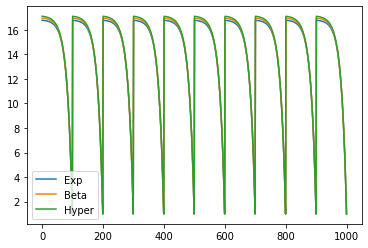

In [10]:
plt.plot(advantages0, label="Exp")
plt.plot(advantages05, label="Beta")
plt.plot(advantages1, label="Hyper")

plt.legend()

In [9]:
λ = 0.95
ep_len = 100
T = 1000


rewards = torch.ones(T)
values = torch.zeros(T)
dones = torch.tensor([False for _ in range(T)])


_, advantages0 = discount_bgae(rewards, values, dones, 0.99, 0., λ, ep_len)
_, advantages05 = discount_bgae(rewards, values, dones, 0.99, 0.5, λ, ep_len)
_, advantages1 = discount_bgae(rewards, values, dones, 0.99, 1., λ, ep_len)

In [68]:
advantages05

tensor([0.0028, 0.0029, 0.0031, 0.0033, 0.0035, 0.0037, 0.0039, 0.0042, 0.0044,
        0.0047, 0.0050, 0.0053, 0.0056, 0.0059, 0.0063, 0.0066, 0.0070, 0.0075,
        0.0079, 0.0084, 0.0089, 0.0094, 0.0100, 0.0106, 0.0112, 0.0119, 0.0126,
        0.0134, 0.0142, 0.0151, 0.0160, 0.0170, 0.0180, 0.0191, 0.0202, 0.0215,
        0.0228, 0.0241, 0.0256, 0.0272, 0.0288, 0.0306, 0.0324, 0.0344, 0.0365,
        0.0387, 0.0411, 0.0436, 0.0463, 0.0491, 0.0521, 0.0553, 0.0587, 0.0623,
        0.0661, 0.0701, 0.0744, 0.0790, 0.0839, 0.0890, 0.0945, 0.1003, 0.1065,
        0.1131, 0.1200, 0.1274, 0.1353, 0.1437, 0.1525, 0.1620, 0.1720, 0.1827,
        0.1940, 0.2060, 0.2188, 0.2324, 0.2468, 0.2622, 0.2785, 0.2959, 0.3143,
        0.3339, 0.3548, 0.3769, 0.4005, 0.4255, 0.4522, 0.4805, 0.5106, 0.5427,
        0.5768, 0.6130, 0.6516, 0.6926, 0.7362, 0.7826, 0.8320, 0.8846, 0.9405,
        1.0000])

In [58]:
advantages1

tensor([0.0031, 0.0033, 0.0035, 0.0037, 0.0039, 0.0041, 0.0044, 0.0046, 0.0049,
        0.0052, 0.0055, 0.0058, 0.0061, 0.0065, 0.0069, 0.0073, 0.0077, 0.0082,
        0.0086, 0.0091, 0.0097, 0.0102, 0.0108, 0.0115, 0.0121, 0.0129, 0.0136,
        0.0144, 0.0153, 0.0162, 0.0171, 0.0181, 0.0192, 0.0203, 0.0215, 0.0228,
        0.0241, 0.0256, 0.0271, 0.0287, 0.0304, 0.0322, 0.0341, 0.0361, 0.0383,
        0.0406, 0.0430, 0.0455, 0.0482, 0.0511, 0.0542, 0.0574, 0.0609, 0.0645,
        0.0684, 0.0725, 0.0768, 0.0814, 0.0863, 0.0915, 0.0970, 0.1029, 0.1091,
        0.1157, 0.1227, 0.1301, 0.1380, 0.1464, 0.1553, 0.1647, 0.1747, 0.1854,
        0.1967, 0.2087, 0.2215, 0.2350, 0.2494, 0.2647, 0.2810, 0.2982, 0.3166,
        0.3361, 0.3568, 0.3789, 0.4023, 0.4273, 0.4538, 0.4819, 0.5119, 0.5438,
        0.5777, 0.6138, 0.6522, 0.6931, 0.7366, 0.7829, 0.8322, 0.8846, 0.9405,
        1.0000])

In [9]:
advantages[:500]

tensor([99.3429, 99.3363, 99.3296, 99.3228, 99.3160, 99.3091, 99.3021, 99.2950,
        99.2879, 99.2807, 99.2735, 99.2661, 99.2587, 99.2512, 99.2437, 99.2360,
        99.2283, 99.2205, 99.2126, 99.2047, 99.1966, 99.1885, 99.1803, 99.1721,
        99.1637, 99.1552, 99.1467, 99.1381, 99.1294, 99.1206, 99.1117, 99.1027,
        99.0937, 99.0845, 99.0753, 99.0659, 99.0565, 99.0470, 99.0373, 99.0276,
        99.0178, 99.0079, 98.9978, 98.9877, 98.9775, 98.9672, 98.9567, 98.9462,
        98.9356, 98.9248, 98.9139, 98.9030, 98.8919, 98.8807, 98.8694, 98.8580,
        98.8464, 98.8348, 98.8230, 98.8111, 98.7991, 98.7870, 98.7747, 98.7624,
        98.7499, 98.7372, 98.7245, 98.7116, 98.6986, 98.6854, 98.6722, 98.6588,
        98.6452, 98.6315, 98.6177, 98.6037, 98.5896, 98.5754, 98.5610, 98.5465,
        98.5318, 98.5169, 98.5020, 98.4868, 98.4715, 98.4561, 98.4405, 98.4248,
        98.4089, 98.3928, 98.3765, 98.3602, 98.3436, 98.3269, 98.3100, 98.2929,
        98.2756, 98.2582, 98.2406, 98.22

In [ ]:
import pdb; pdb.pm()

> /Users/redtachyon/projects/CrowdAI/coltra/bgae.py(65)_discount_bgae()
     63 
     64         future_rewards = (λ_v * Γ_v) @ s_rewards
---> 65         future_values = (1-λ) * (λ_v * Γ_v1) @ s_values
     66 
     67         advantage = -old_value + future_rewards + future_values



ipdb>  (1-λ) * (λ_v * Γ_v1)


array([0.0495    , 0.04655709, 0.04379132, 0.04119189, 0.03874864,
       0.03645208, 0.03429326, 0.03226383, 0.03035592, 0.02856216,
       0.02687564, 0.02528985, 0.0237987 , 0.02239648, 0.0210778 ,
       0.01983765, 0.01867126, 0.01757422, 0.01654234, 0.01557171,
       0.01465864, 0.01379968, 0.01299159, 0.01223132, 0.01151601,
       0.01084296, 0.01020965, 0.00961372, 0.00905292, 0.00852516,
       0.00802848, 0.00756102, 0.00712104, 0.00670692, 0.00631712,
       0.00595019, 0.00560478, 0.0052796 , 0.00497348, 0.00468526,
       0.00441391, 0.00415841, 0.00391784, 0.00369132, 0.00347801,
       0.00327714, 0.00308797, 0.00290982, 0.00274203, 0.00258401],
      dtype=float32)


ipdb>  ((1-λ) * (λ_v * Γ_v1)).shape


(50,)


ipdb>  s_values.shape


(49, 20)


ipdb>  00


0


In [13]:
get_beta_vector(100, 0, )

ZeroDivisionError: division by zero